**Инициализация графов Таллина (Эстония) и Риги (Латвия)**

***Отрисовка графов автодорог***

In [1]:
import osmnx as ox
import pandas as pd
import networkx as nx

def func(x):
    return x[0]

def func_1(x):
    gdf_1 = ox.geocode_to_gdf(x, by_osmid=True)
    return gdf_1[['lat', 'lon']]

def func_tags(tags, city):
    try:
        gdf = ox.features_from_place(city, tags)
    except ox._errors.InsufficientResponseError:
        return None
    gdf = gdf[['name', 'geometry', 'nodes']]
    gdf = gdf.dropna().reset_index()
    gdf['n_osmid'] = gdf['element_type'].apply(func) + gdf['osmid'].astype(str)
    ex = [gdf['n_osmid'].apply(func_1).iloc[:].values[x] for x in range(len(gdf))]
    dfs = pd.concat(ex, axis=0).reset_index(drop=True)
    gdf = gdf.merge(dfs, on=dfs.index)
    gdf = gdf.drop('key_0', axis=1)
    gdf = gdf[['name', 'lat', 'lon', 'geometry', 'nodes']]
    gdf['kind_of'] = list(tags.keys())[0]
    return gdf

tags_port = {'industrial' : 'port'}
tags_aeroway = {'aeroway' : ['aerodrome','heliport', 'airstrip']}
tags_landuse = {'landuse' : 'railway'}
tags_build = {'building' : 'warehouse', 'amenity' : 'mailroom'}

city_from = 'Tallin'
city_to = 'Riga'

full_df_from = pd.concat([func_tags(tags_port, city_from), func_tags(tags_aeroway, city_from), func_tags(tags_landuse, city_from), func_tags(tags_build, city_from)], ignore_index=True)
full_df_to = pd.concat([func_tags(tags_port, city_to), func_tags(tags_aeroway, city_to), func_tags(tags_landuse, city_to), func_tags(tags_build, city_to)], ignore_index=True)

G_from = ox.graph_from_place(city_from, retain_all=True, simplify = True, network_type='drive')
G_to = ox.graph_from_place(city_to, retain_all=True, simplify = True, network_type='drive')

lat_from = list(full_df_from['lat'].values)
lon_from = list(full_df_from['lon'].values)

lat_to = list(full_df_to['lat'].values)
lon_to = list(full_df_to['lon'].values)

full_graph = nx.compose_all([G_from, G_to])
full_df_from['new_nodes'] = ox.distance.nearest_nodes(full_graph, lon_from, lat_from)
full_df_to['new_nodes'] = ox.distance.nearest_nodes(full_graph, lon_to, lat_to)

C:\Users\orenc\AppData\Local\Temp\ipykernel_8508\2630940479.py:3: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  full_graph_from_bbox = ox.graph_from_bbox(bbox = (north, south, east, west), network_type='drive')
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


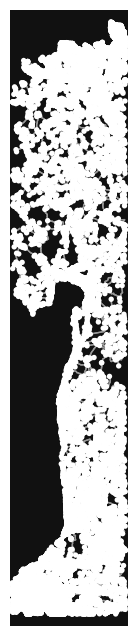

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
gdf_nodes, gdf_relationships = ox.graph_to_gdfs(full_graph)
north, south, east, west = gdf_nodes[['y']].max(), gdf_nodes[['y']].min(), gdf_nodes[['x']].min(), gdf_nodes[['x']].max()
full_graph_from_bbox = ox.graph_from_bbox(bbox = (north, south, east, west), network_type='drive')
ox.plot_graph(full_graph_from_bbox)

___

***Отрисова графа ЖД-путей***

C:\Users\orenc\AppData\Local\Temp\ipykernel_8508\3741340674.py:7: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  full_graph_from_bbox_railway = ox.graph_from_bbox(bbox = (north, south, east, west), simplify=True, retain_all=True, custom_filter = '["railway"~"."]')
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


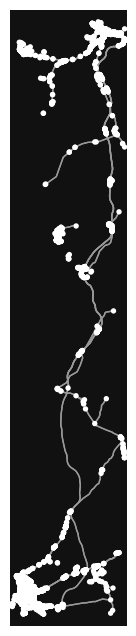

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
G_from_railway = ox.graph_from_place(city_from, simplify=False, retain_all=True, custom_filter = '["railway"~"."]')
G_to_railway = ox.graph_from_place(city_to, simplify=False, retain_all=True, custom_filter = '["railway"~"."]')
full_graph_railway = nx.compose_all([G_from_railway, G_to_railway])

gdf_nodes, gdf_relationships = ox.graph_to_gdfs(full_graph_railway)
north, south, east, west = gdf_nodes[['y']].max(), gdf_nodes[['y']].min(), gdf_nodes[['x']].min(), gdf_nodes[['x']].max()
full_graph_from_bbox_railway = ox.graph_from_bbox(bbox = (north, south, east, west), simplify=True, retain_all=True, custom_filter = '["railway"~"."]')

ox.plot_graph(full_graph_from_bbox_railway)

___

***Отрисовка морского пути***

In [4]:
from scgraph.geographs.marnet import marnet_geograph

output = marnet_geograph.get_shortest_path(
    origin_node={"latitude": 57.026087,"longitude": 24.075463}, 
    destination_node={"latitude": 59.444022,"longitude": 24.774418}
)

In [5]:
list_lat_marine = [output['coordinate_path'][i][0] for i in range(len(output['coordinate_path']))]
list_lon_marine = [output['coordinate_path'][i][1] for i in range(len(output['coordinate_path']))]
full_df_marine = pd.DataFrame({'x' : list_lon_marine, 'y' : list_lat_marine})
full_df_marine['new_nodes'] = ox.distance.nearest_nodes(full_graph_from_bbox, list_lon_marine, list_lat_marine)
full_df_marine['osmid'] = full_df_marine['new_nodes']
full_df_marine = full_df_marine.set_index('osmid')

In [6]:
import geopandas as gd
edge_dict = {'u': full_df_marine.new_nodes[:-1].values, 'v': full_df_marine.new_nodes[1:].values, 'key': 0}
edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

In [7]:
graph_attrs = {"crs": "WGS84"}
multi_digraph = ox.convert.graph_from_gdfs(
    full_df_marine, edge_gdf, graph_attrs=graph_attrs)

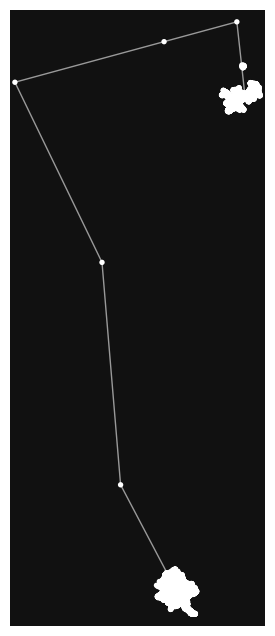

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
full_graph_with_marine = nx.compose_all([G_from, G_to, multi_digraph])
ox.plot_graph(full_graph_with_marine)

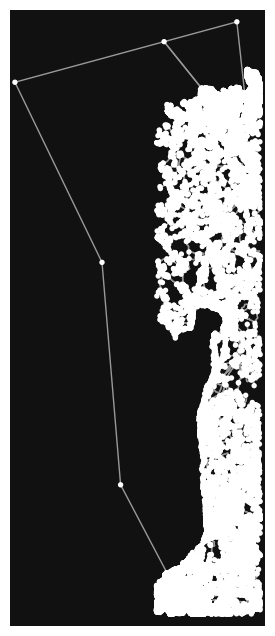

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
full_graph_with_marine_and_railway = nx.compose_all([full_graph_from_bbox, full_graph_from_bbox_railway, multi_digraph])
ox.plot_graph(full_graph_with_marine_and_railway)

___

***Отрисовка аэропути***

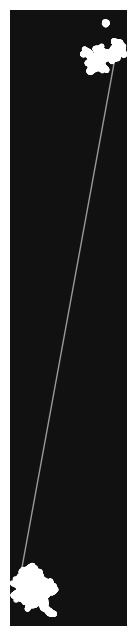

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [41]:
list_lat_aero_from = full_df_from[full_df_from['kind_of'] == 'aeroway'].lat.to_list()
list_lon_aero_from = full_df_from[full_df_from['kind_of'] == 'aeroway'].lon.to_list()
list_lat_aero_to = full_df_to[full_df_to['kind_of'] == 'aeroway'].lat.to_list()
list_lon_aero_to = full_df_to[full_df_to['kind_of'] == 'aeroway'].lon.to_list()
full_list_lat_aero = list_lat_aero_from + list_lat_aero_to
full_list_lon_aero = list_lon_aero_from + list_lon_aero_to
full_df_aero = pd.DataFrame({'x' : full_list_lon_aero, 'y' : full_list_lat_aero})
full_df_aero['new_nodes'] = ox.distance.nearest_nodes(full_graph_from_bbox, full_list_lon_aero, full_list_lat_aero)
full_df_aero['osmid'] = full_df_aero['new_nodes']
full_df_aero = full_df_aero.set_index('osmid')

edge_dict = {'u': full_df_aero.new_nodes[:-1].values, 'v': full_df_aero.new_nodes[1:].values, 'key': 0}
edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

graph_attrs = {"crs": "WGS84"}
multi_digraph_aero = ox.convert.graph_from_gdfs(
    full_df_aero, edge_gdf, graph_attrs=graph_attrs)

full_graph_with_aero = nx.compose_all([G_from, G_to, multi_digraph_aero])
ox.plot_graph(full_graph_with_aero)

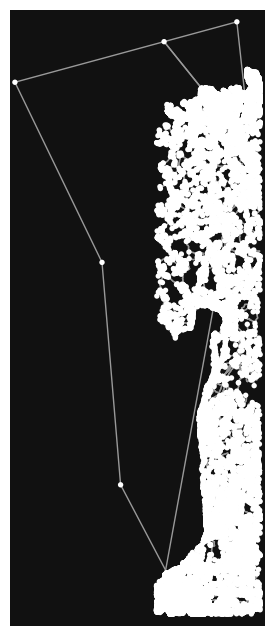

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [42]:
full_graph_with_marine_and_railway_and_aero = nx.compose_all([full_graph_with_marine_and_railway, multi_digraph_aero])
ox.plot_graph(full_graph_with_marine_and_railway_and_aero)

___

***Попытка отрисовать все пути***

*Весь граф*

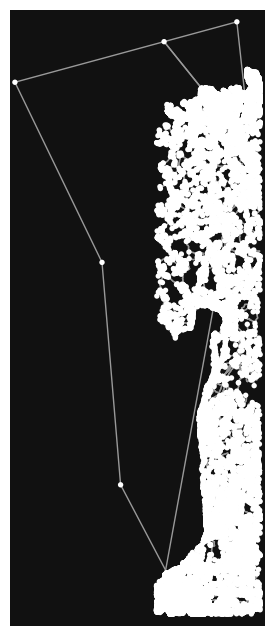

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [62]:
all_graphs = nx.compose_all([full_graph_from_bbox, full_graph_from_bbox_railway, multi_digraph, multi_digraph_aero])
ox.distance.add_edge_lengths(all_graphs, edges=None)
ox.plot_graph(all_graphs)

*Путь от аэропорта до склада*

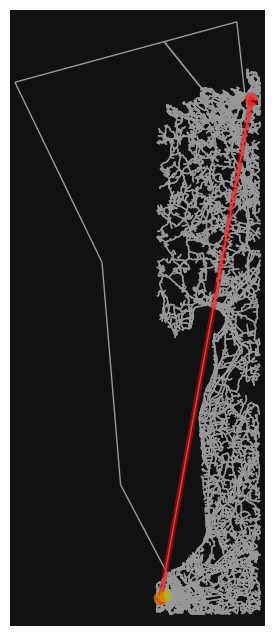

In [65]:
route_aero = nx.shortest_path(all_graphs, 989935973, 3793834493)
route_drive = nx.shortest_path(all_graphs, 3793834493, 257594899)
routes = [route_aero, route_drive]
rc = ['r', 'y']
fig, ax = ox.plot_graph_routes(all_graphs, routes, route_colors=rc, route_linewidth=6, node_size=0)

*Путь от порта до склада*

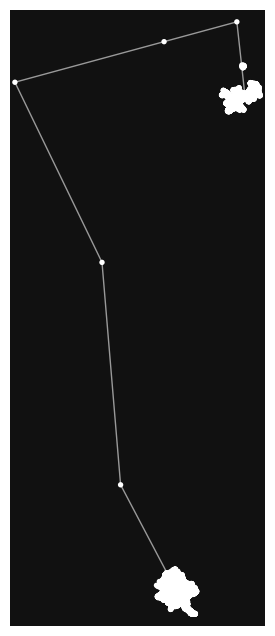

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [67]:
ox.distance.add_edge_lengths(full_graph_with_marine, edges=None)
ox.plot_graph(full_graph_with_marine)

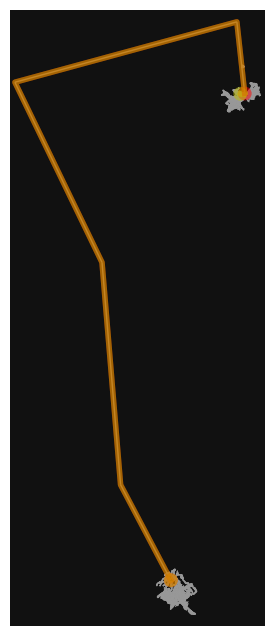

In [76]:
route_marine = nx.shortest_path(full_graph_with_marine, 28781831, 6726297219)
route_drive = nx.shortest_path(full_graph_with_marine, 28781831, 146399104)
routes = [route_marine, route_drive]
rc = ['r', 'y']
fig, ax = ox.plot_graph_routes(full_graph_with_marine, routes, route_colors=rc, route_linewidth=6, node_size=0)

*Путь от ЖД-станции до склада*

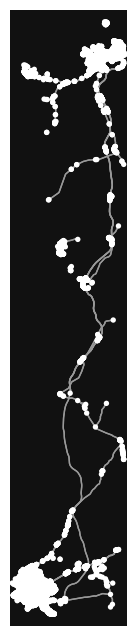

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [78]:
graph_railway = nx.compose_all([full_graph_from_bbox_railway, G_from, G_to])
ox.distance.add_edge_lengths(graph_railway, edges=None)
ox.plot_graph(graph_railway)

In [88]:
route = nx.shortest_path(graph_railway, 4622582280, 10188918307)
fig, ax = ox.plot_graph_route(graph_railway, route, route_linewidth=6, node_size=0, bgcolor='k')

NetworkXNoPath: No path between 4622582280 and 10188918307.

___

ВСПОМОГАТЕЛЬНЫЕ ДАННЫЕ

In [46]:
full_df_from

,name,lat,lon,geometry,nodes,kind_of,new_nodes
0,Paljassaare sadam,59.460184,24.707205,"POLYGON ((24.69967 59.45667, 24.69970 59.45668...","[[[962086465, 2354993602, 5133797405, 51338011...",industrial,278364190
1,Vanasadam,59.444022,24.774418,"MULTIPOLYGON (((24.75972 59.44545, 24.76040 59...","[[[9055928766, 294510701, 11741309866, 5884596...",industrial,6726297219
2,Tallinna lennujaam,59.414383,24.836851,"POLYGON ((24.87762 59.41361, 24.87396 59.41454...","[521306701, 521306702, 4264883505, 4264883510,...",aeroway,989935973
3,Kopli kaubajaam,59.443773,24.719722,"POLYGON ((24.71114 59.44733, 24.71154 59.44724...","[1129498488, 1129498522, 1129498530, 105958075...",landuse,11780904
4,Balti jaam,59.438961,24.733923,"POLYGON ((24.72755 59.43723, 24.73247 59.43881...","[7548499852, 8511990149, 8511990150, 419963212...",landuse,4622582280
5,Ülemiste kaubajaam,59.422168,24.830341,"POLYGON ((24.79486 59.42350, 24.79518 59.42354...","[[[294495944, 715799245, 715478528, 715478629,...",landuse,693191997
6,Horeca Service,59.419784,24.798040,"POLYGON ((24.79849 59.41946, 24.79878 59.41966...","[294494744, 2129683691, 294494749, 294494746, ...",building,291750883
7,Valukoja parkimismaja,59.420184,24.801119,"POLYGON ((24.80042 59.42027, 24.80042 59.42006...","[294531623, 294531630, 294531631, 3437214004, ...",building,293896194
8,Premia Tallinna Külmhoone,59.428557,24.846480,"POLYGON ((24.84560 59.42886, 24.84567 59.42875...","[294533602, 1635514916, 1635514918, 1635514917...",building,12293081
9,Hoovimaja 3,59.411573,24.736587,"POLYGON ((24.73671 59.41144, 24.73687 59.41160...","[294487206, 294487207, 294487208, 294487201, 1...",building,385950102


In [47]:
full_df_to

,name,lat,lon,geometry,nodes,kind_of,new_nodes
0,Rīgas brīvosta,57.026087,24.075463,"POLYGON ((24.06378 57.03245, 24.06380 57.03252...","[[[985282153, 985260293, 1920155370, 511767981...",industrial,28781831
1,RIX Rīgas lidosta,56.922240,23.972643,"POLYGON ((23.96558 56.91633, 23.96555 56.91854...","[[[1049528523, 2240021665, 7846932944, 1090107...",aeroway,3793834493
2,CD-2,56.978840,24.162009,"POLYGON ((24.16057 56.97887, 24.16283 56.97926...","[965041381, 965041374, 1603453451, 3129242428,...",landuse,381079379
3,Iļģuciems,56.974538,24.068620,"POLYGON ((24.07045 56.97244, 24.07075 56.97253...","[2805942721, 2805942723, 2805942720, 280594271...",landuse,4169551868
4,CD-12,56.925092,24.082713,"POLYGON ((24.08112 56.92233, 24.08153 56.92228...","[3370228435, 10018640703, 3370228434, 11157841...",landuse,1116775568
5,Torņakalns,56.931466,24.088113,"POLYGON ((24.08211 56.92276, 24.08282 56.92413...","[11157841785, 3370228445, 3370228452, 21546203...",landuse,26841535
6,Čiekurkalns,56.980573,24.168683,"POLYGON ((24.15620 56.97738, 24.15641 56.97729...","[3695317916, 3695317915, 3695317917, 369531792...",landuse,391548329
7,Jugla,56.991539,24.232765,"POLYGON ((24.21370 56.98775, 24.21379 56.98762...","[7506275730, 7506275731, 7506275738, 750627573...",landuse,3044193808
8,Stacija Bolderāja-2,56.993759,24.048367,"POLYGON ((24.04774 56.99267, 24.04763 56.99273...","[[[7460918392, 7460918391], [7460918391, 74609...",landuse,3682329653
9,Zemitāni,56.963967,24.157143,"POLYGON ((24.15336 56.97202, 24.15335 56.97201...","[[[10216024287, 2954394205, 1854742381, 316175...",landuse,10188918307
